**Zachary Torstrick  
Module 5 Check-In  
ATMS 523  
Fall 2025**

# Homework: Compare Two Logistic Regression Models (Weather & Climate)

**Compare the performance of two logistic regression models**  
- **Model A (Full):** `CAPE`, `PWAT`, `Shear`  
- **Model B (Reduced):** `CAPE`, only

Does the three parameter model work better than the one parameter model?

**Tasks**
1. Split data into train/test.
2. Fit both models.
3. Compute **accuracy**, **precision**, **recall** at threshold 0.5.
4. Plot **ROC** and **Precision–Recall** curves for both models on the same figures.
5. Answer the interpretation questions.


In [56]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    precision_score, 
    recall_score, 
    accuracy_score, 
    roc_curve, 
    auc, 
    precision_recall_curve)


FEATURES_FULL = ['cape','pwat','shear']
FEATURES_REDUCED = ['cape']
TARGET = 'event'

# Synthetic fallback
USE_SYNTHETIC = True

if USE_SYNTHETIC:
    rng = np.random.default_rng(42)
    n = 1200
    cape  = rng.gamma(5.0, 250.0, size=n)
    pwat  = rng.normal(30, 8, size=n).clip(5, 70)
    shear = rng.normal(15, 6, size=n).clip(0, 40)
    z = -6.0 + 0.0025*cape + 0.06*pwat + 0.05*shear + 0.00002*cape*shear
    p = 1/(1+np.exp(-z))
    y = rng.binomial(1, p)
    df = pd.DataFrame({'cape':cape, 'pwat':pwat, 'shear':shear, 'event':y})
else:
    df = pd.read_csv('../data/your_data.csv').dropna()
    assert TARGET in df.columns
    assert all(c in df.columns for c in FEATURES_FULL)
    df = df[FEATURES_FULL + [TARGET]]
df.head()

,cape,pwat,shear,event
0,1339.091679,24.846334,4.350342,1
1,1620.699558,34.709626,23.376549,1
2,1237.079261,26.431445,20.809474,1
3,1157.616507,37.841527,29.506833,1
4,1708.955858,32.249385,6.662860,1


## 1) Train/Test Split

In [57]:
# Split into train/test for both feature sets using SAME random_state and stratify by y
X_full = df[FEATURES_FULL].values
X_reduced = df[FEATURES_REDUCED].values
y = df[TARGET].values.astype(int)

Xf_train, Xf_test, yf_train, yf_test = train_test_split(
    X_full, y, test_size=0.25, random_state=0, stratify=y)
Xr_train, Xr_test, yr_train, yr_test = train_test_split(
    X_reduced, y, test_size=0.25, random_state=0, stratify=y)

len(Xf_train), len(Xf_test)

(900, 300)

## 2) Fit Both Logistic Regression Models

In [58]:
# Fit two LogisticRegression models (full and reduced). Use max_iter >= 200.
clf_full = LogisticRegression(max_iter=200).fit(
    Xf_train, yf_train)
clf_reduced = LogisticRegression(max_iter=200).fit(
    Xr_train, yr_train)

yprob_full = clf_full.predict_proba(Xf_test)[:, 1]
yprob_reduced = clf_reduced.predict_proba(Xr_test)[:, 1]

clf_full.coef_, clf_reduced.coef_

(array([[0.00294362, 0.0514564 , 0.0928135 ]]), array([[0.00269818]]))

## 3) Metrics at Threshold 0.5

In [59]:
thr = 0.5
ypred_full = (yprob_full >= thr).astype(int)
ypred_reduced = (yprob_reduced >= thr).astype(int)

# Compute metrics for Full Model
acc_full = accuracy_score(yf_test, ypred_full)
prec_full = precision_score(yf_test, ypred_full)
rec_full = recall_score(yf_test, ypred_full)

# Compute metrics for Reduced Model
acc_reduced = accuracy_score(yr_test, ypred_reduced)
prec_reduced = precision_score(yr_test, ypred_reduced)
rec_reduced = recall_score(yr_test, ypred_reduced)

# Display results
print("Full Model (CAPE + PWAT + Shear):")
print(f"  Accuracy:  {acc_full:.3f}")
print(f"  Precision: {prec_full:.3f}")
print(f"  Recall:    {rec_full:.3f}")

print("\nReduced Model (CAPE only):")
print(f"  Accuracy:  {acc_reduced:.3f}")
print(f"  Precision: {prec_reduced:.3f}")
print(f"  Recall:    {rec_reduced:.3f}")

Full Model (CAPE + PWAT + Shear):
  Accuracy:  0.723
  Precision: 0.733
  Recall:    0.678

Reduced Model (CAPE only):
  Accuracy:  0.717
  Precision: 0.736
  Recall:    0.651


## 4) Plot ROC and Precision–Recall Curves

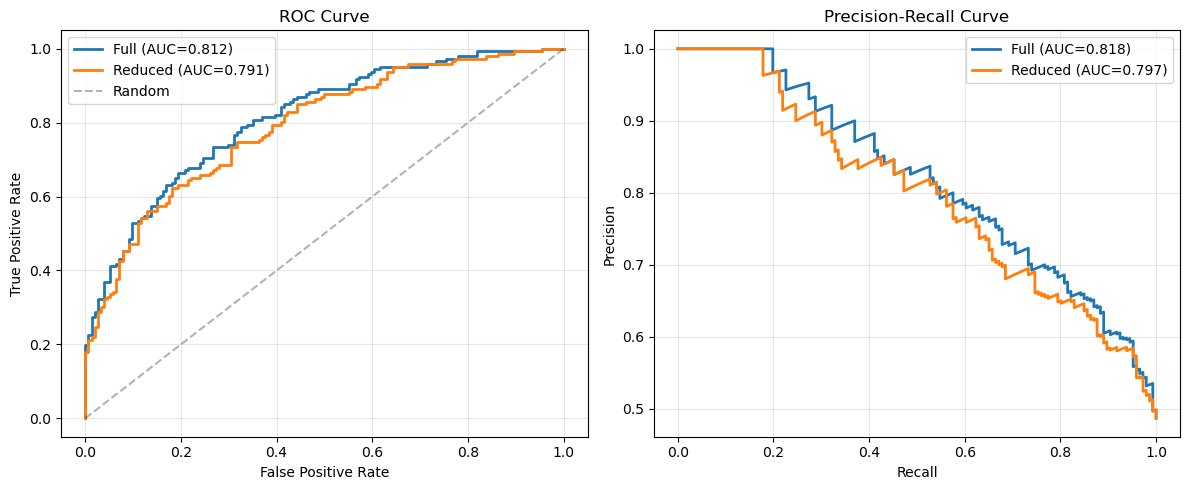

In [60]:
# Plot ROC and PR curves for both models on shared axes

# Full
fpr_full, tpr_full, _ = roc_curve(yf_test, yprob_full)
roc_auc_full = auc(fpr_full, tpr_full)
prec_full, rec_full, _ = precision_recall_curve(yf_test, yprob_full)
pr_auc_full = auc(rec_full, prec_full)

# Reduced
fpr_reduced, tpr_reduced, _ = roc_curve(yr_test, yprob_reduced)
roc_auc_reduced = auc(fpr_reduced, tpr_reduced)
prec_reduced, rec_reduced, _ = precision_recall_curve(yr_test, yprob_reduced)
pr_auc_reduced = auc(rec_reduced, prec_reduced)

# Plot setup
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot ROC curves
ax1.plot(
    fpr_full, 
    tpr_full, 
    label=f'Full (AUC={roc_auc_full:.3f})', 
    linewidth=2)
ax1.plot(
    fpr_reduced, 
    tpr_reduced, 
    label=f'Reduced (AUC={roc_auc_reduced:.3f})', 
    linewidth=2)
ax1.plot([0, 1], [0, 1], 'k--', label='Random', alpha=0.3)
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.set_title('ROC Curve')
ax1.legend()
ax1.grid(alpha=0.3)

# Plot Precision-Recall curves
ax2.plot(
    rec_full, 
    prec_full, 
    label=f'Full (AUC={pr_auc_full:.3f})', 
    linewidth=2)
ax2.plot(
    rec_reduced, 
    prec_reduced, 
    label=f'Reduced (AUC={pr_auc_reduced:.3f})', 
    linewidth=2)
ax2.set_xlabel('Recall')
ax2.set_ylabel('Precision')
ax2.set_title('Precision-Recall Curve')
ax2.legend()
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()


## 5) Interpretation

1. Which model has higher **ROC-AUC** and **PR-AUC**? What does this imply about `PWAT`?  
2. Compare **accuracy**, **precision**, and **recall** for both models.  
   - Which model would you choose to **maximize event detection** (recall)?  
   - Which model would you choose to **minimize false alarms** (precision)?  

1\. The full model for both ROC and PR. This implies that PWAT and Shear are important.

From Previous Cell
```
Full Model (CAPE + PWAT + Shear):
  Accuracy:  0.723
  Precision: 0.733
  Recall:    0.678

Reduced Model (CAPE only):
  Accuracy:  0.717
  Precision: 0.736
  Recall:    0.651
```

2\.  
 Recall: full model  
 Precision: reduced model  
